### Step 1
Analyse the data in the raw dataset answering the following questions (note, you are free to choose the suitable methods ofthe analysis yourself, based on your knowledge of e.g. applied statistics or other courses of your study)

In [135]:
import pandas as pd
from scipy.stats import chisquare
import numpy as np 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import matplotlib.pyplot as plt
import functions

In [136]:
# reading in the data
survey_data = pd.read_excel("data/private_dataE.xlsx")
results_data = pd.read_excel("data/public_data_resultsE.xlsx")
pub_data_register = pd.read_excel('data/public_data_registerE.xlsx')

#### Data cleanup

In [137]:
# naming the unnamed column to "where voting" as it refers to polling stations and evotes
results_data = results_data.rename(columns = {"Unnamed: 0":"where_voting"})

# creating a transformed version of the results data for evotes vs polling stations
def rename(x): 
    if "Polling station" in x: 
        return "Polling station"
    else: 
        return "E-votes"
transformed_results_data = results_data.copy()
transformed_results_data["where_voting"]= transformed_results_data["where_voting"].apply(lambda x: rename(x))
agg_functions = {'Red': 'sum','Green': 'sum', 'Invalid ballots': 'sum' ,'Total': 'sum'  }
new_results_data = transformed_results_data.groupby(transformed_results_data["where_voting"]).aggregate(agg_functions).reset_index()

### (A) 

Is there a significant difference between the political preferences as expressed in the survey and the election results for bothelectronic and polling station votes?

In [ ]:
# Count votes by political preference within each voting type
preference_counts = survey_data.groupby(["evote", "party"]).size().unstack(fill_value=0).reset_index()
preference_counts["total"]= preference_counts[['Green', 'Red', "Invalid vote"]].sum(axis=1)
# Calculate proportions for each political preference within each voting type
preference_counts.head()

party,evote,Green,Invalid vote,Red,total
0,0,88,3,47,138
1,1,43,0,19,62


In [139]:
# Calculating proportions for political preferences in the public results data
new_results_data.head()

,where_voting,Red,Green,Invalid ballots,Total
0,E-votes,489,913,28,1430
1,Polling station,273,475,12,760


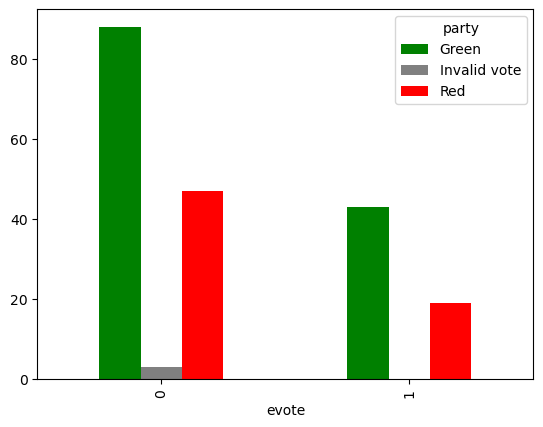

In [140]:
# Define a color list for each party
party_colors = ["green", "gray", "red"]

# Plot the survey data
plot_data = survey_data.groupby(["evote", "party"]).size().unstack().plot(kind='bar',color=party_colors)


<Axes: xlabel='where_voting'>

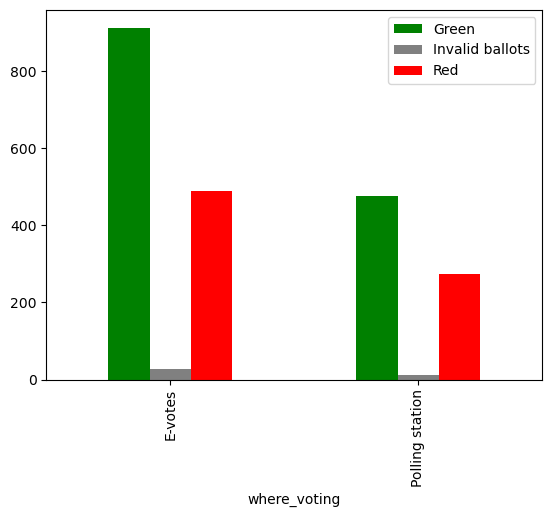

In [141]:
# Plot the results data
new_results_data.plot(
    kind='bar', 
    x='where_voting', 
    y=['Green', 'Invalid ballots', 'Red'], 
    color=party_colors,
)

#### Two sample proportion z-test

In [ ]:
result_green_polling = new_results_data.loc[new_results_data['where_voting'] == 'Polling station', 'Green'].iloc[0]
result_total_polling = new_results_data.loc[new_results_data['where_voting'] == 'Polling station', 'Total'].iloc[0]
survey_green_polling = preference_counts.loc[preference_counts['evote'] == 0, 'Green'].iloc[0]
survey_total_polling = preference_counts.loc[preference_counts['evote'] == 0, 'total'].iloc[0]

result_green_evotes = new_results_data.loc[new_results_data['where_voting'] == 'E-votes', 'Green'].iloc[0]
result_total_evotes = new_results_data.loc[new_results_data['where_voting'] == 'E-votes', 'Total'].iloc[0]
survey_green_evotes = preference_counts.loc[preference_counts['evote'] == 1, 'Green'].iloc[0]
survey_total_evotes = preference_counts.loc[preference_counts['evote'] == 1, 'total'].iloc[0]

print(result_green_evotes, result_total_evotes, survey_green_evotes, survey_total_evotes)


913 1430 43 62


In [143]:
functions.two_sample_z_test(result_green_polling, result_total_polling, survey_green_polling,survey_total_polling )

Z-score: -0.28337848165736645
P-value: 0.7768867217758352
Is it statistically significant?  No.


In [144]:
functions.two_sample_z_test(result_green_evotes, result_total_evotes, survey_green_evotes,survey_total_evotes )

Z-score: -0.8850847590713444
P-value: 0.37611091887805415
Is it statistically significant?  No.


#### Chi-squared test

In [145]:
contingency_table_evote = pd.crosstab(survey_data['evote'], survey_data['party'])
contingency_table_evote.columns.name = None 
contingency_table_evote= contingency_table_evote.reset_index()
contingency_table_evote = contingency_table_evote.rename(columns = {"evote":"where_voting"})
contingency_table_evote = contingency_table_evote.rename(columns = {"Invalid vote":"Invalid ballots"})
contingency_table_evote.loc[contingency_table_evote["where_voting"] == 1, "where_voting"] = "E-votes_s"
contingency_table_evote.loc[contingency_table_evote["where_voting"] == 0, "where_voting"] = "Polling station_s"
evote_survey = contingency_table_evote.loc[1]
polling_survey = contingency_table_evote.loc[0]

In [160]:
new_results_data.loc[new_results_data["where_voting"] == "E-votes", "where_voting"] = "E-votes_r"
new_results_data.loc[new_results_data["where_voting"] == "Polling station", "where_voting"] = "Polling station_r"
new_results_data = new_results_data[["where_voting", "Red", "Green","Invalid ballots"]]
evote_results = new_results_data.loc[0]
polling_results = new_results_data.loc[1]

In [161]:
df_evote = pd.DataFrame()
df_evote=df_evote.append(evote_results)
df_evote=df_evote.append(evote_survey)
df_evote = df_evote.set_index('where_voting')

df_polling = pd.DataFrame()
df_polling=df_polling.append(polling_results)
df_polling=df_polling.append(polling_survey)
df_polling = df_polling.set_index('where_voting')

# polling station 
print("Polling station")
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(df_polling)
print("Chi-square Test Results for Gender vs Political Preference")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

# evotes 
print("Evotes")
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(df_evote)
print("Chi-square Test Results for Gender vs Political Preference")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Polling station
Chi-square Test Results for Gender vs Political Preference
Chi-square statistic: 0.39122741032464753
p-value: 0.8223298351007018
Evotes
Chi-square Test Results for Gender vs Political Preference
Chi-square statistic: 1.715440997596452
p-value: 0.42412778103046767


C:\Users\obe\AppData\Local\Temp\ipykernel_17400\4278227953.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_evote=df_evote.append(evote_results)
C:\Users\obe\AppData\Local\Temp\ipykernel_17400\4278227953.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_evote=df_evote.append(evote_survey)
C:\Users\obe\AppData\Local\Temp\ipykernel_17400\4278227953.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_polling=df_polling.append(polling_results)
C:\Users\obe\AppData\Local\Temp\ipykernel_17400\4278227953.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_polling=df_polling.append(polling_survey)


### (B) 

Is there a significant difference between political preferences of the voters depending on their demographic attributes recorded inthe survey (that is, age, gender, education level...)?

In [162]:
functions.chi2(survey_data['sex'], survey_data['party'])

Chi-square Test Results for sex vs party
Chi-square statistic: 1.0948595723439902
p-value: 0.578434602059867


In [163]:
functions.chi2(survey_data['education'], survey_data['party'])

Chi-square Test Results for education vs party
Chi-square statistic: 34.70051433812302
p-value: 0.0043666219362705665


In [164]:
survey_data['age'] = 2024 - survey_data['dob'].dt.year
functions.chi2(survey_data['age'], survey_data['party'])

Chi-square Test Results for age vs party
Chi-square statistic: 130.03690118193933
p-value: 0.5806961048843412


### (C) 

Is there a significant difference between voter’s choice of the voting channel (that is, if they decide to vote either online or inperson) depending on their demographic attributes recorded in the survey?

In [165]:
functions.chi2(survey_data['sex'], survey_data['evote'])

Chi-square Test Results for sex vs evote
Chi-square statistic: 2.6379263431645796
p-value: 0.10433965288985117


In [167]:
functions.chi2(survey_data['education'], survey_data['evote'])

Chi-square Test Results for education vs evote
Chi-square statistic: 8.784052225187445
p-value: 0.36083942749998765


In [168]:
functions.chi2(survey_data['age'], survey_data['evote'])

Chi-square Test Results for age vs evote
Chi-square statistic: 63.97738150893831
p-value: 0.5821109942082197
